In [141]:
%load_ext autoreload
%autoreload 2

import pathlib

import pandas as pd
pd.set_option('display.float_format', lambda x: '%.1f' % x)

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = "20"

from data_handlers.network import parse_bwms
from data_handlers.procmem import parse_pidstat

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
experiment_path = pathlib.Path(f"/home/jovyan/work/binary_files")

In [147]:
network_df = parse_bwms(experiment_path)

In [167]:
network_df.reset_index().routing.unique()

array(['binary_spray', 'prophet', 'dtlsr', 'epidemic', 'context_epidemic',
       'context_spray', 'context_complex'], dtype=object)

In [149]:
procmem_df = parse_pidstat(experiment_path)

In [166]:
procmem_df.reset_index().routing.unique()

array(['binary_spray', 'prophet', 'dtlsr', 'epidemic', 'context_epidemic',
       'context_spray', 'context_complex'], dtype=object)

In [171]:
merged = procmem_df.merge(network_df, left_index=True, right_index=True).reset_index()

In [211]:
cleared = merged[(merged['routing'] != "context_complex") & (merged['routing'] != "dtlsr") & (merged['routing'] != "prophet")]
cleared['%CPU'] = (cleared['%CPU'] - cleared['%CPU'].min()) / (cleared['%CPU'].max() - cleared['%CPU'].min())
cleared.loc[cleared['routing'] == 'epidemic', 'routing'] = 'a'
cleared.loc[cleared['routing'] == 'context_epidemic', 'routing'] = 'b'
cleared.loc[cleared['routing'] == 'binary_spray', 'routing'] = 'c'
cleared.loc[cleared['routing'] == 'context_spray', 'routing'] = 'd'

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,id,routing,dt,%CPU,RSS,bytes_out/s,Mbit/s
0,10,c,0.0,0.0,1246392,0.0,0.0
1,10,c,1.0,0.0,2820288,47222.0,0.4
2,10,c,2.0,0.0,2823624,67962.0,0.5
3,10,c,3.0,0.0,2823624,9556.0,0.1
4,10,c,4.0,0.0,2823624,1492.0,0.0
...,...,...,...,...,...,...,...
125266,9,c,3633.0,0.0,132793992,6899662.0,52.6
125267,9,c,3634.0,0.0,109238212,7197694.0,54.9
125268,9,c,3635.0,0.0,100680932,6206251.0,47.3
125269,9,c,3636.0,0.0,30901552,6625021.0,50.5


Starting a
Plotting bandwidth for Epidemic
Plotting CPU for Epidemic
Starting b
Plotting bandwidth for Software Defined Epidemic
Plotting CPU for Software Defined Epidemic
Starting c
Plotting bandwidth for Binary Spray & Wait
Plotting CPU for Binary Spray & Wait
Starting d
Plotting bandwidth for Software Defined Binary Spray & Wait
Plotting CPU for Software Defined Binary Spray & Wait


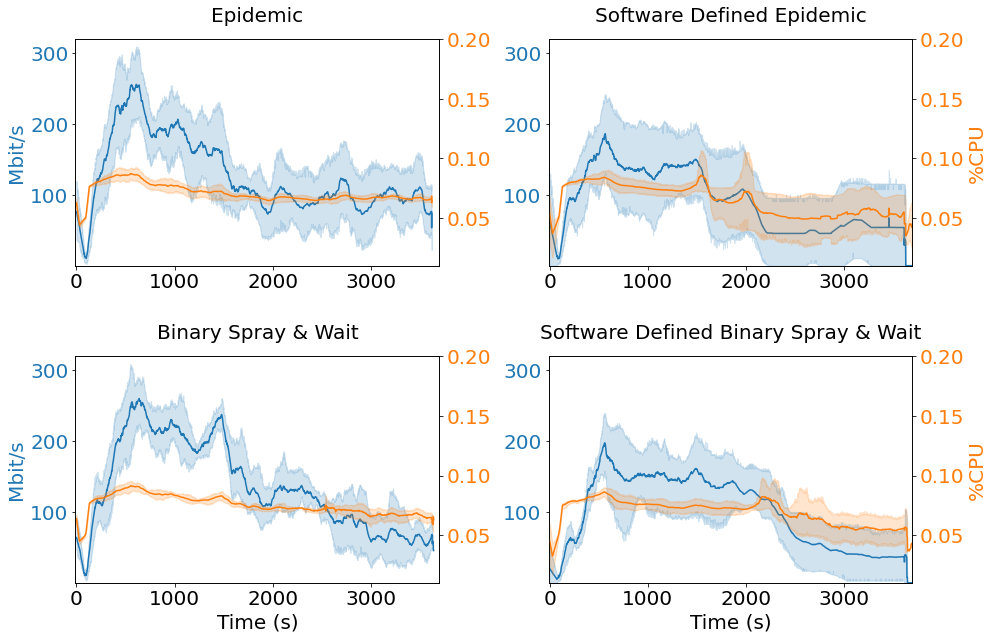

In [217]:
fig, axs = plt.subplots(nrows=2, ncols=2)
plt.subplots_adjust(wspace=.3, hspace=.4)

fig.set_size_inches(15,10)

color_mbit = 'C0'
color_cpu = 'C1'

for ax, (name, routing_df) in zip(list(axs[0]) + list(axs[1]), cleared.groupby(['routing'])):
    print(f"Starting {name}")
    ax.tick_params(axis='y', labelcolor=color_mbit)
    ax.set_xlim(-10, 3700)
    ax.set_ylim(0.01, 320)
    
    if name == "c":
        name = "Binary Spray & Wait"
    if name == "b":
        name = "Software Defined Epidemic"
    if name == "d":
        name = "Software Defined Binary Spray & Wait"
    if name == "a":
        name = "Epidemic"
    ax.set_title(name, fontsize=20)
    
    ax2 = ax.twinx()
    ax2.tick_params(axis='y', labelcolor=color_cpu)
    ax2.set_ylim(.01, .2)
                    
    routing_df = routing_df.reset_index()
    
    #routing_df = routing_df.sample(1000)

    print(f"Plotting bandwidth for {name}")
    sns.lineplot(
        x=routing_df['dt'],
        y=routing_df['Mbit/s'].rolling(100).mean(),
        ax=ax,
        color=color_mbit
    )

    print(f"Plotting CPU for {name}")
    sns.lineplot(
        x=routing_df['dt'],
        y=routing_df['%CPU'].rolling(100).mean(),
        ax=ax2,
        color=color_cpu
    )

    if ax.figbox.x0 == 0.125: #Just some magic number. You can find it with print(ax.figbox)
        ax.set_ylabel('Mbit/s', color=color_mbit)
        ax2.set_ylabel('')
    if ax.figbox.x0 == 0.5630434782608696: #Just some magic number. You can find it with print(ax.figbox)
        ax.set_ylabel('', color=color_mbit)
        ax2.set_ylabel('%CPU', color=color_cpu)

    if ax.figbox.y0 == 0.125: #Just some magic number. You can find it with print(ax.figbox)
        ax.set_xlabel('Time (s)')
    if ax.figbox.y0 == 0.5654166666666667: #Just some magic number. You can find it with print(ax.figbox)
        ax.set_xlabel('')
        
    ttl = ax.title
    ttl.set_position([.5, 1.05])
                        
plt.savefig('cpu_network.pdf')
#plt.show()